In [35]:
import numpy as np
# import cPickle
from collections import defaultdict
import re

import sys
import os
import pandas as pd
os.environ['KERAS_BACKEND']='tensorflow'

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, concatenate, Dropout, GRU, LSTM, Bidirectional
from keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pickle

In [36]:
max_sen_len = 1500
emb_dim = 100
val_split = 0.2

emails = []
labels = []

classes = []
class_labels = {}
class_ind = 0

In [37]:
df = pd.read_csv('./enron_email_lstm.csv')
emails = df['content'].tolist()
labels = df['author'].tolist()



In [38]:
#print(type(emails), type(emails[0]), emails[0][0], emails[0])
# print(labels)
emails_final=[]
for i in emails:
  emails_final.append(str(i))
emails=emails_final

In [39]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(emails)
sequences = tokenizer.texts_to_sequences(emails)

word_index = tokenizer.word_index

data = pad_sequences(sequences, maxlen=max_sen_len)

labels = to_categorical(np.asarray(labels))
print(labels.shape[0], labels.shape[1])

41254 10


In [40]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(val_split * data.shape[0])

In [41]:
x_train,x_test,y_train,y_test=train_test_split(data,labels,train_size=0.8,random_state=42)
#print(x_train)

In [8]:
x_train_normal,x_train_validation,y_train_normal,y_train_validation=train_test_split(x_train,y_train,train_size=0.85,random_state=42)

In [9]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2022-04-27 16:39:14--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-04-27 16:39:14--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-04-27 16:39:15--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [42]:
embeddings_index = {}
with open('glove.6B.100d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

In [43]:
embedding_matrix = np.random.random((len(word_index) + 1, emb_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [44]:
embedding_layer = Embedding(len(word_index) + 1,
                            emb_dim,
                            weights=[embedding_matrix],
                            input_length=max_sen_len,
                            trainable=True)

In [16]:
sequence_input = Input(shape=(max_sen_len,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
l_lstm = Bidirectional(LSTM(100))(embedded_sequences)
dense_1 = Dense(128, activation="relu")(l_lstm)
drop_1 = Dropout(0.3)(dense_1)
preds = Dense(10, activation='softmax')(drop_1)
model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])


In [17]:
print(model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1500)]            0         
                                                                 
 embedding (Embedding)       (None, 1500, 100)         2719200   
                                                                 
 bidirectional_1 (Bidirectio  (None, 200)              160800    
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 128)               25728     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 10)                1290      
                                                           

In [54]:
model.fit(x_train_normal, y_train_normal,validation_data=(x_train_validation,y_train_validation),
          epochs=1, batch_size=128)
filename = 'finalized_model_weights.sav'
pickle.dump(model, open(filename, 'wb'))

220/220 [==============================] - 2068s 9s/step - loss: 0.2284 - acc: 0.9245 - val_loss: 0.5717 - val_acc: 0.8467


INFO:tensorflow:Assets written to: ram://6ae0eb47-c980-44ee-9470-a6f760659999/assets


INFO:tensorflow:Assets written to: ram://6ae0eb47-c980-44ee-9470-a6f760659999/assets


In [56]:
model=pickle.load(open(filename, 'rb'))
y_test_predicted=model.predict(x_test)
print(y_test_predicted)

[[5.1158363e-08 3.3833697e-07 3.0165469e-07 ... 4.7471722e-06
  9.9979573e-01 3.0191512e-09]
 [4.1017599e-13 3.5075064e-12 1.0000000e+00 ... 1.4675749e-12
  2.3826259e-13 1.7636614e-12]
 [9.9999988e-01 1.2568925e-13 5.8907657e-11 ... 1.0441323e-11
  1.1431477e-14 2.6264677e-17]
 ...
 [2.6146320e-01 1.9158579e-02 6.8521969e-02 ... 6.9851995e-02
  1.7303329e-02 1.0340820e-02]
 [2.2819537e-10 2.2279795e-13 3.2426554e-13 ... 1.0857014e-14
  1.3933839e-12 1.6328425e-22]
 [4.3679666e-02 5.7504950e-03 1.1121880e-01 ... 5.1771786e-02
  1.2585295e-02 3.0225415e-02]]


In [57]:

#print(y_test)
y_test_actual=np.argmax(y_test,axis=1)
print(y_test_actual)
y_test_predicted1=np.argmax(y_test_predicted,axis=1)
print(y_test_predicted1)
print(classification_report(y_test_actual,y_test_predicted1))

[8 2 0 ... 2 5 2]
[8 2 0 ... 5 5 3]
              precision    recall  f1-score   support

           0       0.88      0.81      0.84       545
           1       0.97      0.96      0.96       517
           2       0.91      0.85      0.88       888
           3       0.74      0.94      0.83       912
           4       0.87      0.86      0.87       670
           5       0.94      0.98      0.96      1213
           6       0.90      0.77      0.83       538
           7       0.90      0.92      0.91      1591
           8       0.99      0.86      0.92       811
           9       0.99      0.96      0.97       566

    accuracy                           0.90      8251
   macro avg       0.91      0.89      0.90      8251
weighted avg       0.91      0.90      0.90      8251



[[ 452    1    7   10    8   24   37    6    0    0]
 [   0  503    0    1    0    4    1    7    1    0]
 [  13    6  755   13   27    8   19   39    3    5]
 [  22    2   15  777   28   17   29   14    1    7]
 [   5    4    8   12  595    2    9   16   13    6]
 [   2    4    4    1    4 1180    1   11    5    1]
 [  38    1    3    9   15    1  456   11    1    3]
 [  15    3   26   23   55    8   34 1420    6    1]
 [   7    0    5    2   35    4    2   32  722    2]
 [   2    1    3    0    6    1    3    1    2  547]]


[Text(0, 0.5, 'bass-e'),
 Text(0, 1.5, 'beck-s'),
 Text(0, 2.5, 'dasovich-j'),
 Text(0, 3.5, 'germany-c'),
 Text(0, 4.5, 'jones-t'),
 Text(0, 5.5, 'kaminski-v'),
 Text(0, 6.5, 'lenhart-m'),
 Text(0, 7.5, 'mann-k'),
 Text(0, 8.5, 'shackleton-s'),
 Text(0, 9.5, 'symes-k')]

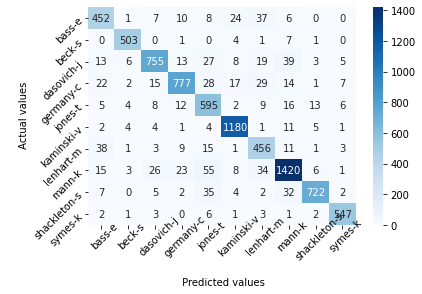

In [53]:
authors=['bass-e', 'beck-s', 'dasovich-j', 'germany-c', 'jones-t',
       'kaminski-v', 'lenhart-m', 'mann-k', 'shackleton-s', 'symes-k']


from matplotlib.pyplot import plot
from sklearn.metrics import confusion_matrix
cf_matrix=confusion_matrix(y_test_actual,y_test_predicted1)
print(cf_matrix)
import seaborn as sns
ax=sns.heatmap(cf_matrix,annot=True,cmap='Blues',fmt='g')
ax.set_xlabel('\n Predicted values')
ax.set_ylabel('\n Actual values')
ax.xaxis.set_ticklabels(authors,rotation=45,rotation_mode='anchor')
ax.yaxis.set_ticklabels(authors,rotation=45,rotation_mode='anchor')
#plot.show()